<a href="https://colab.research.google.com/github/swilsonmfc/trees/blob/master/Dota2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dota

![](https://upload.wikimedia.org/wikipedia/en/0/0b/Dota_2_%28Steam_2019%29.jpg)

# Setup

In [71]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingClassifier

# Data
* https://archive.ics.uci.edu/ml/datasets/Dota2+Games+Results

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00367/dota2Dataset.zip
!unzip dota2Dataset.zip

--2021-04-14 18:33:41--  https://archive.ics.uci.edu/ml/machine-learning-databases/00367/dota2Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1821241 (1.7M) [application/x-httpd-php]
Saving to: ‘dota2Dataset.zip’

dota2Dataset.zip    100%[===================>]   1.74M  3.65MB/s    in 0.5s    

2021-04-14 18:33:42 (3.65 MB/s) - ‘dota2Dataset.zip’ saved [1821241/1821241]

Archive:  dota2Dataset.zip
  inflating: dota2Train.csv          
  inflating: dota2Test.csv           


In [3]:
columns = ['target'] + [f'col_{i}' for i in range(116)]
train_df = pd.read_csv('dota2Train.csv', names=columns)
test_df  = pd.read_csv('dota2Test.csv', names=columns)

In [4]:
train_df

,target,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,...,col_76,col_77,col_78,col_79,col_80,col_81,col_82,col_83,col_84,col_85,col_86,col_87,col_88,col_89,col_90,col_91,col_92,col_93,col_94,col_95,col_96,col_97,col_98,col_99,col_100,col_101,col_102,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,col_112,col_113,col_114,col_115
0,-1,223,2,2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,-1,0,0,0,-1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,152,2,2,0,0,0,1,0,-1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-1,0,0,0,0,1,1,0,0,0,0,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,131,2,2,0,0,0,1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,154,2,2,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0
4,-1,171,2,3,0,0,0,0,0,-1,0,0,-1,0,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92645,-1,154,2,3,1,0,0,-1,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
92646,1,154,2,2,0,0,0,0,-1,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
92647,1,111,2,3,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
92648,-1,185,2,2,0,0,0,0,0,1,0,0,-1,0,0,-1,0,1,-1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Card Names

In [5]:
file = requests.get('https://raw.githubusercontent.com/kronusme/dota2-api/master/data/heroes.json')
file_json = json.loads(file.content)
names_df = pd.json_normalize(file_json, record_path='heroes')
names_df = names_df.sort_values('id')
names_df

,name,id,localized_name
0,antimage,1,Anti-Mage
1,axe,2,Axe
2,bane,3,Bane
3,bloodseeker,4,Bloodseeker
4,crystal_maiden,5,Crystal Maiden
...,...,...,...
106,terrorblade,109,Terrorblade
107,phoenix,110,Phoenix
109,oracle,111,Oracle
110,winter_wyvern,112,Winter Wyvern


## Columns
* Not a perfect match (missing one name)
* Could have alignment issues as well

In [6]:
cols = ['target', 'cluster', 'mode', 'game_type', 'unknown'] + names_df.name.tolist() 

In [7]:
train_df.columns = cols
test_df.columns  = cols

In [8]:
train_df

,target,cluster,mode,game_type,unknown,antimage,axe,bane,bloodseeker,crystal_maiden,drow_ranger,earthshaker,juggernaut,mirana,morphling,nevermore,phantom_lancer,puck,pudge,razor,sand_king,storm_spirit,sven,tiny,vengefulspirit,windrunner,zuus,kunkka,lina,lion,shadow_shaman,slardar,tidehunter,witch_doctor,lich,riki,enigma,tinker,sniper,necrolyte,...,invoker,silencer,obsidian_destroyer,lycan,brewmaster,shadow_demon,lone_druid,chaos_knight,meepo,treant,ogre_magi,undying,rubick,disruptor,nyx_assassin,naga_siren,keeper_of_the_light,wisp,visage,slark,medusa,troll_warlord,centaur,magnataur,shredder,bristleback,tusk,skywrath_mage,abaddon,elder_titan,legion_commander,techies,ember_spirit,earth_spirit,abyssal_underlord,terrorblade,phoenix,oracle,winter_wyvern,arc_warden
0,-1,223,2,2,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,-1,0,0,0,-1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,152,2,2,0,0,0,1,0,-1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-1,0,0,0,0,1,1,0,0,0,0,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,131,2,2,0,0,0,1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,154,2,2,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0
4,-1,171,2,3,0,0,0,0,0,-1,0,0,-1,0,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92645,-1,154,2,3,1,0,0,-1,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
92646,1,154,2,2,0,0,0,0,-1,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
92647,1,111,2,3,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
92648,-1,185,2,2,0,0,0,0,0,1,0,0,-1,0,0,-1,0,1,-1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Data Types

In [9]:
#for card in train_df.columns[1:]:
#  train_df[card] = train_df[card].astype('category')
#  test_df[card] = test_df[card].astype('category')

# EDA

## Decks

In [10]:
train_df.loc[:, 'unknown':]

,unknown,antimage,axe,bane,bloodseeker,crystal_maiden,drow_ranger,earthshaker,juggernaut,mirana,morphling,nevermore,phantom_lancer,puck,pudge,razor,sand_king,storm_spirit,sven,tiny,vengefulspirit,windrunner,zuus,kunkka,lina,lion,shadow_shaman,slardar,tidehunter,witch_doctor,lich,riki,enigma,tinker,sniper,necrolyte,warlock,beastmaster,queenofpain,venomancer,...,invoker,silencer,obsidian_destroyer,lycan,brewmaster,shadow_demon,lone_druid,chaos_knight,meepo,treant,ogre_magi,undying,rubick,disruptor,nyx_assassin,naga_siren,keeper_of_the_light,wisp,visage,slark,medusa,troll_warlord,centaur,magnataur,shredder,bristleback,tusk,skywrath_mage,abaddon,elder_titan,legion_commander,techies,ember_spirit,earth_spirit,abyssal_underlord,terrorblade,phoenix,oracle,winter_wyvern,arc_warden
0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,-1,0,0,0,-1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,-1,0,0,...,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,-1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-1,0,0,0,0,1,1,0,0,0,0,0,0,0,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,-1,0,0,-1,0,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92645,1,0,0,-1,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
92646,0,0,0,0,-1,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
92647,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
92648,0,0,0,0,0,1,0,0,-1,0,0,-1,0,1,-1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
# Everyone has the same number of cards
train_df.loc[:, 'unknown':].sum(axis=1).value_counts()

0    92650
dtype: int64

In [12]:
# Five cards for +1 Deck, mutually exclusive
(train_df.loc[:, 'unknown':] == 1).sum(axis=1).value_counts()

5    92650
dtype: int64

In [13]:
# Five cards for -1 Deck, mutually exclusive
(train_df.loc[:, 'unknown':] == -1).sum(axis=1).value_counts()

5    92650
dtype: int64

## Cards

In [14]:
# Ten most played cards
(train_df.loc[:, 'unknown':] != 0).sum(axis=0).sort_values().tail(10)

riki                19670
antimage            20264
invoker             21262
crystal_maiden      21700
slark               23125
earthshaker         23327
legion_commander    26521
puck                28285
phantom_assassin    29802
juggernaut          32048
dtype: int64

In [15]:
# Ten least played cards
(train_df.loc[:, 'unknown':] != 0).sum(axis=0).sort_values().head(10)

abyssal_underlord       0
kunkka                  0
chen                  790
visage                888
brewmaster           1558
lone_druid           1575
wisp                 1592
arc_warden           1791
broodmother          1960
earth_spirit         2253
dtype: int64

## Games

In [16]:
# Not a perfect balance, but fairly close
train_df.value_counts('target')

target
 1    48782
-1    43868
dtype: int64

## Cluster

In [17]:
## Clusters are not same sized
train_df.groupby('cluster').size()

cluster
111     838
112     804
121     714
122     662
123     663
124     664
131     756
132     749
133     762
134     645
135     605
136     613
137     617
138     695
144    1202
145    1242
151    6848
152    6715
153    6757
154    7013
155    6611
156    6899
161     244
171    1122
181    1183
182    1377
183     943
184     974
185     968
186    1090
187    1257
188    1190
191     923
192     828
204    1463
211      18
212      11
213      89
223    3501
224    5963
225    2643
227    7874
231    3666
232    1706
241     127
251     154
261     262
dtype: int64

## Game Mode

In [18]:
# Several different types of game play
train_df.groupby('mode').size()

mode
1     1229
2    71897
3      386
4      208
5       12
6      498
7       81
8     8306
9    10033
dtype: int64

## Game Type

In [19]:
train_df.groupby('game_type').size()

game_type
1       15
2    56988
3    35647
dtype: int64

# Model

In [20]:
results_df = pd.DataFrame(columns=['Accuracy'])

## Fit
* Note, I'm dropping cluster - I won't have a cluster for new observations

In [21]:
y = train_df['target']
X = train_df.drop(columns=['target', 'cluster'])

In [22]:
model = GradientBoostingClassifier(n_estimators=350, 
                                   verbose=2,
                                   learning_rate=0.1,
                                   max_depth=5,
                                   random_state=0)
model.fit(X, y)

      Iter       Train Loss   Remaining Time 
         1           1.3811            2.70m
         2           1.3792            2.65m
         3           1.3773            2.62m
         4           1.3757            2.60m
         5           1.3741            2.62m
         6           1.3727            2.61m
         7           1.3713            2.58m
         8           1.3701            2.56m
         9           1.3688            2.56m
        10           1.3676            2.55m
        11           1.3664            2.54m
        12           1.3653            2.52m
        13           1.3643            2.51m
        14           1.3632            2.49m
        15           1.3621            2.49m
        16           1.3610            2.47m
        17           1.3600            2.46m
        18           1.3592            2.44m
        19           1.3582            2.43m
        20           1.3573            2.42m
        21           1.3563            2.41m
        2

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=350,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=2,
                           warm_start=False)

## Test

In [23]:
y_test = test_df['target']
X_test = test_df.drop(columns=['target', 'cluster'])

In [24]:
pred = model.predict(X_test)

In [25]:
score = accuracy_score(y_test, pred)
results_df.loc['GBM'] = score
score

0.6007382941519331

## Learning

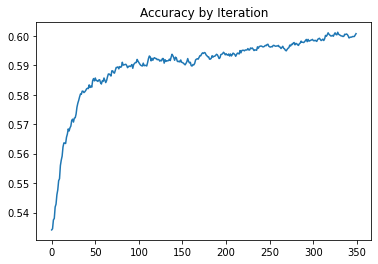

In [26]:
accuracy = []
for i, pred in enumerate(model.staged_predict(X_test)):
  accuracy.append(accuracy_score(y_test, pred))
plt.plot(accuracy)
plt.title('Accuracy by Iteration');

## Importance

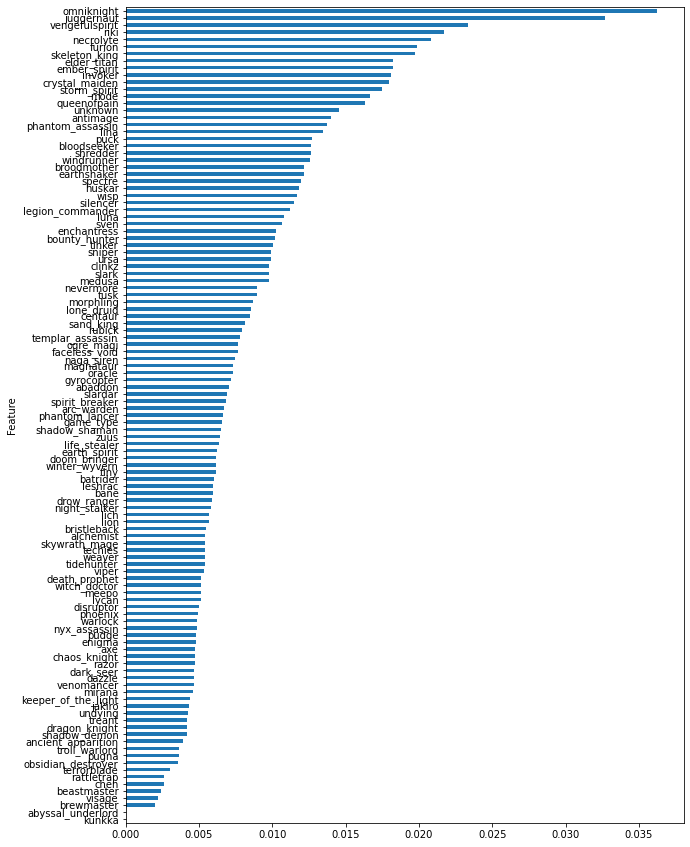

In [27]:
# Importance
features = zip(X.columns, model.feature_importances_)
feature_df = pd.DataFrame(features, columns=['Feature', 'Importance']).sort_values('Importance')
feature_df = feature_df.set_index('Feature')
feature_df['Importance'].plot.barh(figsize=(10, 15));

# Reframing

In [28]:
reframe_df = train_df.copy()
loss_df = train_df.copy()
loss_df['target'] = loss_df['target'] * -1
for col in loss_df.columns[4:]:
  loss_df[col] = loss_df[col] * -1
reframe_df = pd.concat([reframe_df, loss_df])

In [29]:
len(reframe_df)

185300

## Fit

In [30]:
y = reframe_df['target']
X = reframe_df.drop(columns=['target', 'cluster'])

In [31]:
model = GradientBoostingClassifier(n_estimators=350, 
                                   verbose=2,
                                   min_samples_leaf=10,
                                   min_samples_split=20,
                                   learning_rate=0.1,
                                   max_depth=5,
                                   random_state=0)
model.fit(X, y)

      Iter       Train Loss   Remaining Time 
         1           1.3842            5.93m
         2           1.3823            5.84m
         3           1.3808            5.84m
         4           1.3794            5.78m
         5           1.3782            5.74m
         6           1.3770            5.71m
         7           1.3759            5.65m
         8           1.3748            5.61m
         9           1.3737            5.59m
        10           1.3728            5.54m
        11           1.3718            5.50m
        12           1.3709            5.46m
        13           1.3701            5.43m
        14           1.3692            5.41m
        15           1.3684            5.39m
        16           1.3676            5.36m
        17           1.3668            5.34m
        18           1.3661            5.32m
        19           1.3654            5.30m
        20           1.3645            5.30m
        21           1.3639            5.28m
        2

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=20,
                           min_weight_fraction_leaf=0.0, n_estimators=350,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=2,
                           warm_start=False)

## Test

In [32]:
y_test = test_df['target']
X_test = test_df.drop(columns=['target', 'cluster'])

In [33]:
pred = model.predict(X_test)

In [34]:
score = accuracy_score(y_test, pred)
results_df.loc['GBM - Reframed Data'] = score
score

0.5973382552943463

## Learning

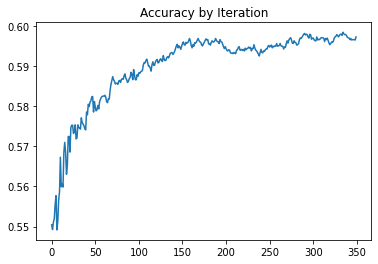

In [35]:
accuracy = []
for i, pred in enumerate(model.staged_predict(X_test)):
  accuracy.append(accuracy_score(y_test, pred))
plt.plot(accuracy)
plt.title('Accuracy by Iteration');

## Importance

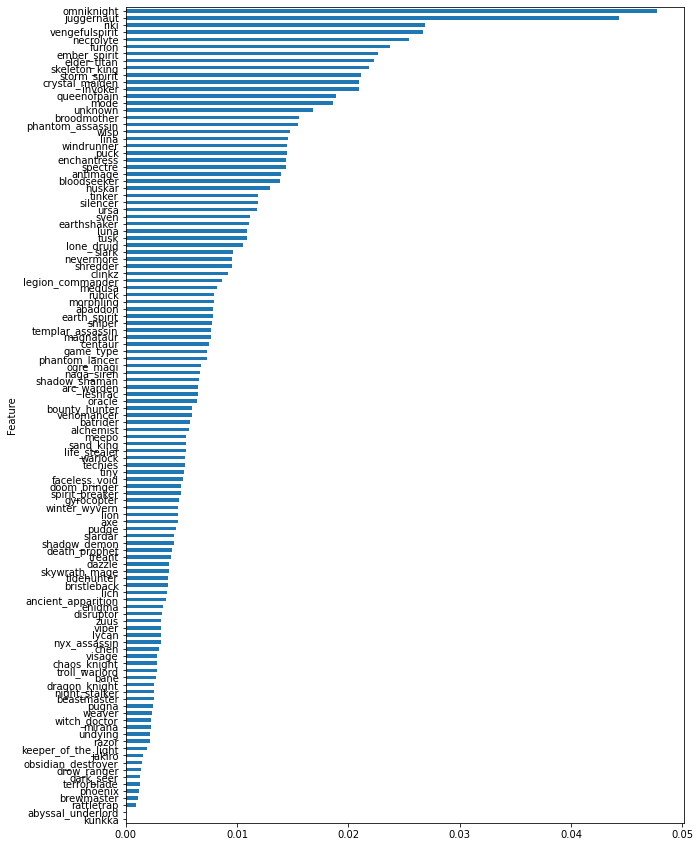

In [36]:
features = zip(X.columns, model.feature_importances_)
feature_df = pd.DataFrame(features, columns=['Feature', 'Importance']).sort_values('Importance')
feature_df = feature_df.set_index('Feature')
feature_df['Importance'].plot.barh(figsize=(10, 15));

In [37]:
pd.crosstab(y, X.omniknight)

omniknight,-1,0,1
target,,,
-1,5063,84330,3257
1,3257,84330,5063


In [38]:
pd.crosstab(y, X.juggernaut)

juggernaut,-1,0,1
target,,,
-1,17729,60602,14319
1,14319,60602,17729


# Interaction

In [39]:
# Juggernaut is a good feature, what other cards are associated with it?
cross_df = reframe_df.copy()
cross_df = cross_df.replace(-1, 0) 
cross_df[cross_df.juggernaut == 1].sum().sort_values()[-15:-5]

shredder            2812
faceless_void       3033
invoker             3148
antimage            3252
crystal_maiden      3488
slark               3674
earthshaker         3906
phantom_assassin    4029
legion_commander    4090
puck                4321
dtype: int64

## Interaction

In [40]:
cards = ['shredder',
  'faceless_void',
  'invoker',
  'antimage',
  'crystal_maiden',
  'slark',
  'earthshaker',
  'phantom_assassin',
  'legion_commander',
  'puck']

cross_df = reframe_df.copy()
cross_test_df = test_df.copy()

for card in cards:
  cross_df[f'juggernaut_{card}'] = np.where((cross_df.juggernaut == 1) & (cross_df[card] == 1), 1, 0)
  cross_test_df[f'juggernaut_{card}'] = np.where((cross_test_df.juggernaut == 1) & (cross_test_df[card] == 1), 1, 0)

## Fit

In [41]:
X = cross_df.copy()
y = X['target']
X = X.drop(columns=['target', 'cluster'])

In [42]:
model = GradientBoostingClassifier(n_estimators=350, 
                                   verbose=2,
                                   min_samples_leaf=10,
                                   min_samples_split=20,
                                   learning_rate=0.1,
                                   max_depth=5,
                                   random_state=0)
model.fit(X, y)

      Iter       Train Loss   Remaining Time 
         1           1.3842            6.25m
         2           1.3824            6.16m
         3           1.3808            6.08m
         4           1.3794            6.06m
         5           1.3782            6.05m
         6           1.3770            6.03m
         7           1.3759            6.00m
         8           1.3748            5.97m
         9           1.3737            5.93m
        10           1.3727            5.89m
        11           1.3718            5.86m
        12           1.3709            5.84m
        13           1.3701            5.82m
        14           1.3692            5.80m
        15           1.3684            5.77m
        16           1.3676            5.75m
        17           1.3669            5.72m
        18           1.3661            5.70m
        19           1.3654            5.67m
        20           1.3646            5.65m
        21           1.3639            5.62m
        2

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=20,
                           min_weight_fraction_leaf=0.0, n_estimators=350,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=2,
                           warm_start=False)

## Test

In [43]:
y_test = cross_test_df['target']
X_test = cross_test_df.drop(columns=['target', 'cluster'])

In [44]:
pred = model.predict(X_test)

In [45]:
score = accuracy_score(y_test, pred)
results_df.loc['GBM - Top Card Interaction'] = score
score

0.59636681562075

## Learning

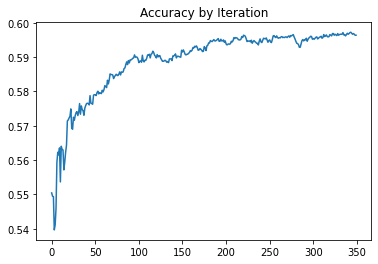

In [46]:
accuracy = []
for i, pred in enumerate(model.staged_predict(X_test)):
  accuracy.append(accuracy_score(y_test, pred))
plt.plot(accuracy)
plt.title('Accuracy by Iteration');

## Importance

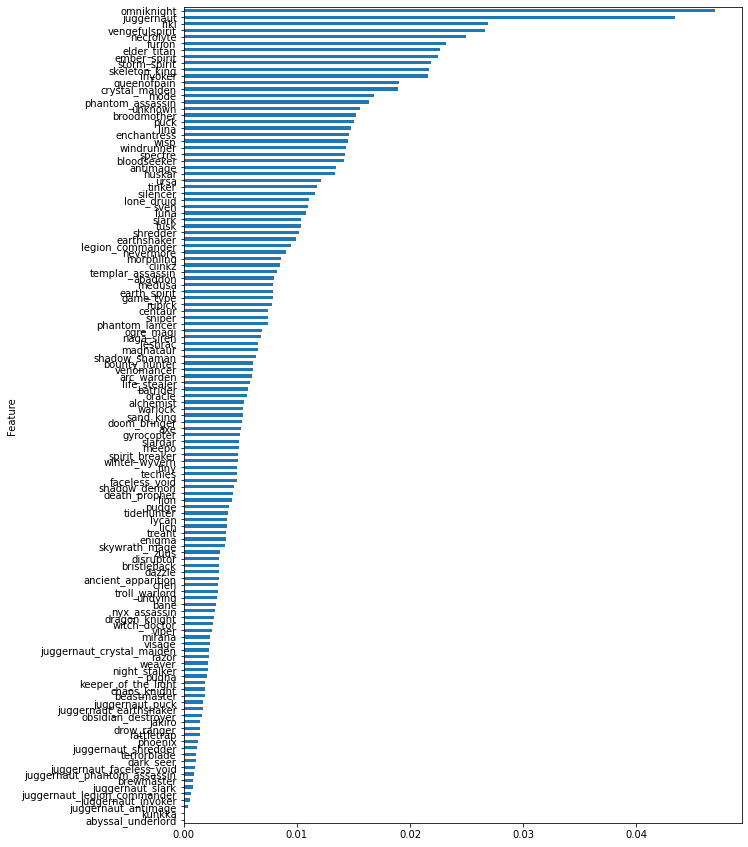

In [47]:
features = zip(X.columns, model.feature_importances_)
feature_df = pd.DataFrame(features, columns=['Feature', 'Importance']).sort_values('Importance')
feature_df = feature_df.set_index('Feature')
feature_df['Importance'].plot.barh(figsize=(10, 15));

In [48]:
features = zip(X.columns, model.feature_importances_)
feature_df = pd.DataFrame(features, columns=['Feature', 'Importance']).sort_values('Importance')
feature_df = feature_df.set_index('Feature')
jugger_df = feature_df[feature_df.index.str.startswith('jugger') == True]
jugger_df

,Importance
Feature,
juggernaut_antimage,0.000415
juggernaut_invoker,0.000553
juggernaut_legion_commander,0.000679
juggernaut_slark,0.000806
juggernaut_phantom_assassin,0.000956
juggernaut_faceless_void,0.001037
juggernaut_shredder,0.001213
juggernaut_earthshaker,0.001687
juggernaut_puck,0.001696


# Top 10 Interactions

In [49]:
def top_interactions(df, card):
  int_df = df.copy()
  int_df = int_df.replace(-1, 0) 
  top = int_df[int_df[card] == 1].sum().sort_values()[-15:-5]
  return top.keys().tolist()

In [50]:
cross_df = reframe_df.copy()
cross_test_df = test_df.copy()

In [51]:
for card in cross_df.columns[4:]:
  interactions = top_interactions(cross_df, card)
  for interact in interactions:
    cross_df[f'{card}_{interact}']      = np.where((cross_df[card] == 1) & (cross_df[interact] == 1), 1, 0)
    cross_test_df[f'{card}_{interact}'] = np.where((cross_test_df[card] == 1) & (cross_test_df[interact] == 1), 1, 0)

## Fit

In [52]:
X = cross_df.copy()
y = X['target']
X = X.drop(columns=['target', 'cluster'])

In [53]:
model = GradientBoostingClassifier(n_estimators=350, 
                                   verbose=2,
                                   min_samples_leaf=1,
                                   min_samples_split=2,
                                   learning_rate=0.1,
                                   max_depth=5,
                                   random_state=0)
model.fit(X, y)

      Iter       Train Loss   Remaining Time 
         1           1.3842           42.79m
         2           1.3823           41.86m
         3           1.3808           41.26m
         4           1.3794           41.29m
         5           1.3781           41.37m
         6           1.3769           41.01m
         7           1.3757           40.80m
         8           1.3746           40.73m
         9           1.3736           40.53m
        10           1.3725           40.37m
        11           1.3715           40.16m
        12           1.3706           39.99m
        13           1.3697           39.77m
        14           1.3688           39.60m
        15           1.3680           39.37m
        16           1.3673           39.05m
        17           1.3665           38.90m
        18           1.3657           38.74m
        19           1.3650           38.55m
        20           1.3642           38.44m
        21           1.3635           38.23m
        2

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=350,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=2,
                           warm_start=False)

## Test

In [54]:
y_test = cross_test_df['target']
X_test = cross_test_df.drop(columns=['target', 'cluster'])

In [55]:
pred = model.predict(X_test)

In [56]:
score = accuracy_score(y_test, pred)
results_df.loc['GBM - Top 10 Interactions'] = score
score

0.5934524965999611

## Learning

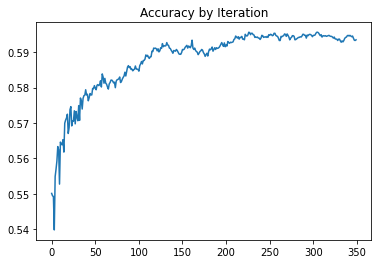

In [57]:
accuracy = []
for i, pred in enumerate(model.staged_predict(X_test)):
  accuracy.append(accuracy_score(y_test, pred))
plt.plot(accuracy)
plt.title('Accuracy by Iteration');

## Importance

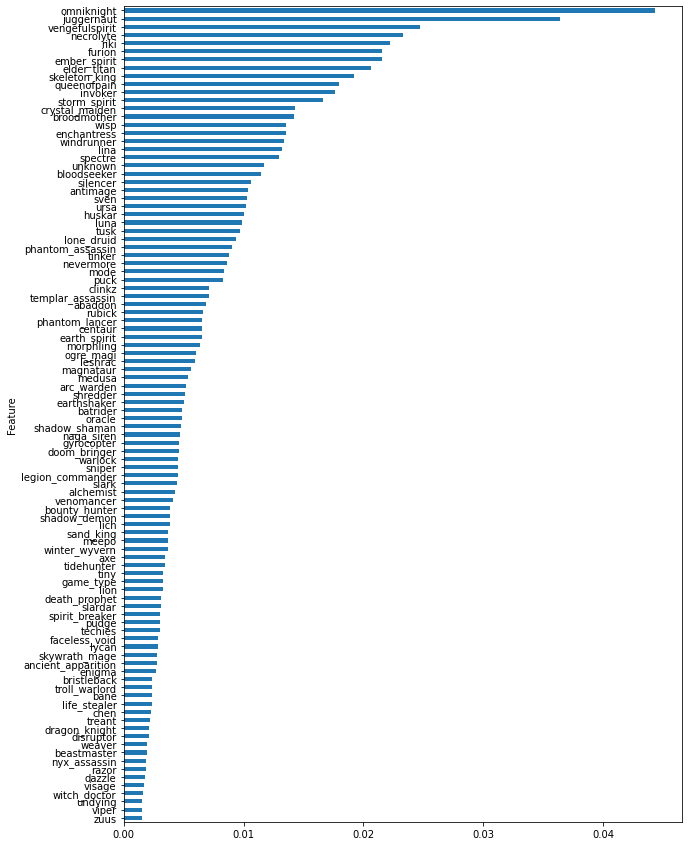

In [58]:
features = zip(X.columns, model.feature_importances_)
feature_df = pd.DataFrame(features, columns=['Feature', 'Importance']).sort_values('Importance')
feature_df = feature_df.set_index('Feature')
feature_df.tail(100)['Importance'].plot.barh(figsize=(10, 15));

# Parsimony

In [59]:
selected = feature_df.tail(100).index.tolist()
selected

['zuus',
 'viper',
 'undying',
 'witch_doctor',
 'visage',
 'dazzle',
 'razor',
 'nyx_assassin',
 'beastmaster',
 'weaver',
 'disruptor',
 'dragon_knight',
 'treant',
 'chen',
 'life_stealer',
 'bane',
 'troll_warlord',
 'bristleback',
 'enigma',
 'ancient_apparition',
 'skywrath_mage',
 'lycan',
 'faceless_void',
 'techies',
 'pudge',
 'spirit_breaker',
 'slardar',
 'death_prophet',
 'lion',
 'game_type',
 'tiny',
 'tidehunter',
 'axe',
 'winter_wyvern',
 'meepo',
 'sand_king',
 'lich',
 'shadow_demon',
 'bounty_hunter',
 'venomancer',
 'alchemist',
 'slark',
 'legion_commander',
 'sniper',
 'warlock',
 'doom_bringer',
 'gyrocopter',
 'naga_siren',
 'shadow_shaman',
 'oracle',
 'batrider',
 'earthshaker',
 'shredder',
 'arc_warden',
 'medusa',
 'magnataur',
 'leshrac',
 'ogre_magi',
 'morphling',
 'earth_spirit',
 'centaur',
 'phantom_lancer',
 'rubick',
 'abaddon',
 'templar_assassin',
 'clinkz',
 'puck',
 'mode',
 'nevermore',
 'tinker',
 'phantom_assassin',
 'lone_druid',
 'tusk',


## Fit
* Dropped the features, increase estimators

In [60]:
X = cross_df[selected].copy()
y = cross_df['target'].copy()

In [61]:
model = GradientBoostingClassifier(n_estimators=500, 
                                   verbose=2,
                                   min_samples_leaf=1,
                                   min_samples_split=2,
                                   learning_rate=0.1,
                                   max_depth=5,
                                   random_state=0)
model.fit(X, y)

      Iter       Train Loss   Remaining Time 
         1           1.3841            7.96m
         2           1.3823            7.85m
         3           1.3808            7.76m
         4           1.3794            7.71m
         5           1.3781            7.66m
         6           1.3769            7.61m
         7           1.3758            7.55m
         8           1.3747            7.48m
         9           1.3736            7.47m
        10           1.3726            7.42m
        11           1.3717            7.39m
        12           1.3708            7.36m
        13           1.3699            7.33m
        14           1.3690            7.31m
        15           1.3681            7.29m
        16           1.3673            7.25m
        17           1.3665            7.22m
        18           1.3657            7.19m
        19           1.3649            7.17m
        20           1.3642            7.14m
        21           1.3634            7.13m
        2

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=2,
                           warm_start=False)

## Test

In [62]:
y_test = cross_test_df['target']
X_test = cross_test_df[selected]

In [63]:
pred = model.predict(X_test)

In [64]:
score = accuracy_score(y_test, pred)
results_df.loc['GBM - Top 100 Features'] = score
score

0.5935496405673207

## Learning

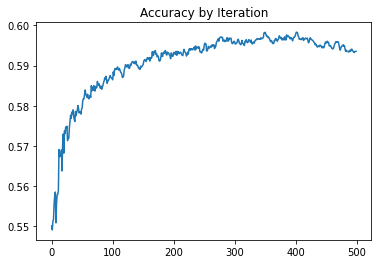

In [65]:
accuracy = []
for i, pred in enumerate(model.staged_predict(X_test)):
  accuracy.append(accuracy_score(y_test, pred))
plt.plot(accuracy)
plt.title('Accuracy by Iteration');

# Results
* Stuck around 60% Accuracy
* Not surprising
  * Deck alone doesn't win
  * Skill / Experience is a factor
* Deck builds don't seem to be huge factor (interactions not moving the needle)

In [66]:
results_df

,Accuracy
GBM,0.600738
GBM - Reframed Data,0.597338
GBM - Top Card Interaction,0.596367
GBM - Top 10 Interactions,0.593452
GBM - Top 100 Features,0.593550


# Hypertuning

In [ ]:
X = train_df.copy()
y = train_df['target'].copy()
X = X.drop(columns=['target'])

## Tune Estimators

In [76]:
tune1   = {'n_estimators':range(20, 100, 10)}
search1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                              min_samples_split=1500,
                                                              min_samples_leaf=150,
                                                              max_depth=8,
                                                              max_features='sqrt',
                                                              subsample=0.8,
                                                              random_state=0), 
                       param_grid = tune1, 
                       scoring='roc_auc',
                       n_jobs=1, 
                       cv=5)
search1.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=8,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=150,
                                                  min_samples_split=1500,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
  

In [78]:
search1.best_params_

{'n_estimators': 90}

## Tune Max Depth

In [79]:
tune2 = {'max_depth':range(4, 16, 2)}
search2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                              n_estimators=90,
                                                              min_samples_split=1500,
                                                              min_samples_leaf=150,
                                                              max_depth=8,
                                                              max_features='sqrt',
                                                              subsample=0.8,
                                                              random_state=0), 
                       param_grid = tune2, 
                       scoring='roc_auc',
                       n_jobs=1, 
                       cv=5)
search2.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=8,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=150,
                                                  min_samples_split=1500,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=90,
                                                  n_iter_no_change=None,
   

In [80]:
search2.best_params_

{'max_depth': 14}

## Tune Min Samples

In [81]:
tune3 = {'min_samples_split':range(500, 2001, 500),
         'min_samples_leaf' :range(500, 2001, 500)}
search3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                              n_estimators=90,
                                                              min_samples_split=1500,
                                                              min_samples_leaf=150,
                                                              max_depth= 14 ,
                                                              max_features='sqrt',
                                                              subsample=0.8,
                                                              random_state=0), 
                       param_grid = tune3, 
                       scoring='roc_auc',
                       n_jobs=1, 
                       cv=5)
search3.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=14,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=150,
                                                  min_samples_split=1500,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=90,
                                                  n_iter_no_change=None,
  

In [82]:
search3.best_params_

{'min_samples_leaf': 500, 'min_samples_split': 500}

## Tune Max Features

In [83]:
tune4 = {'max_features':range(6, 20, 2)}
search4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                              n_estimators=90,
                                                              min_samples_split=500,
                                                              min_samples_leaf=500,
                                                              max_depth= 14 ,
                                                              max_features= 'sqrt',
                                                              subsample=0.8,
                                                              random_state=0), 
                       param_grid = tune4, 
                       scoring='roc_auc',
                       n_jobs=1, 
                       cv=5)
search4.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=14,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=500,
                                                  min_samples_split=500,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=90,
                                                  n_iter_no_change=None,
   

In [84]:
search4.best_params_

{'max_features': 18}

## Tune Subsample

In [85]:
tune5 = {'subsample': [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]}
search5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                              n_estimators=90,
                                                              min_samples_split=500,
                                                              min_samples_leaf=500,
                                                              max_depth= 14 ,
                                                              max_features= 18,
                                                              subsample=0.8,
                                                              random_state=0), 
                       param_grid = tune5, 
                       scoring='roc_auc',
                       n_jobs=1, 
                       cv=5)
search5.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=14,
                                                  max_features=18,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=500,
                                                  min_samples_split=500,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=90,
                                                  n_iter_no_change=None,
       

In [87]:
search5.best_params_

{'subsample': 0.85}

## Estimate Performance

In [88]:
model1 = GradientBoostingClassifier(n_estimators=90, 
                                   verbose=2,
                                   learning_rate=0.1,
                                   min_samples_split=500,
                                   min_samples_leaf=500,
                                   max_depth=14,
                                   max_features= 18,
                                   subsample=0.85,
                                   random_state=0)
model1.fit(X, y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3803           0.0030           16.05s
         2           1.3782           0.0026           15.16s
         3           1.3753           0.0019           15.07s
         4           1.3729           0.0016           14.83s
         5           1.3716           0.0016           14.82s
         6           1.3698           0.0018           14.86s
         7           1.3676           0.0015           14.86s
         8           1.3665           0.0013           14.56s
         9           1.3645           0.0011           14.35s
        10           1.3631           0.0011           14.28s
        11           1.3617           0.0009           14.13s
        12           1.3605           0.0009           13.99s
        13           1.3593           0.0009           13.87s
        14           1.3580           0.0011           13.73s
        15           1.3562           0.0005           13.54s
       

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=14,
                           max_features=18, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=500, min_samples_split=500,
                           min_weight_fraction_leaf=0.0, n_estimators=90,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=0.85, tol=0.0001,
                           validation_fraction=0.1, verbose=2,
                           warm_start=False)

In [91]:
y_test = test_df['target']
X_test = test_df.drop(columns=['target'])

In [92]:
pred = model1.predict(X_test)

In [93]:
score = accuracy_score(y_test, pred)
results_df.loc['Tuned GBM - Learning Rate 0.1'] = score
score

0.5930639207305226

## Drop Learning Rate

In [113]:
model2 = GradientBoostingClassifier(n_estimators=900, 
                                   verbose=2,
                                   learning_rate=0.01,
                                   min_samples_split=500,
                                   min_samples_leaf=500,
                                   max_depth=14,
                                   max_features= 18,
                                   subsample=0.85,
                                   random_state=0)
model2.fit(X, y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3831           0.0003            2.72m
         2           1.3832           0.0003            2.76m
         3           1.3825           0.0002            2.76m
         4           1.3819           0.0002            2.69m
         5           1.3822           0.0002            2.71m
         6           1.3817           0.0003            2.73m
         7           1.3813           0.0002            2.73m
         8           1.3813           0.0003            2.70m
         9           1.3807           0.0003            2.70m
        10           1.3807           0.0002            2.70m
        11           1.3803           0.0003            2.70m
        12           1.3802           0.0002            2.70m
        13           1.3798           0.0002            2.70m
        14           1.3796           0.0002            2.70m
        15           1.3792           0.0002            2.68m
       

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=14,
                           max_features=18, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=500, min_samples_split=500,
                           min_weight_fraction_leaf=0.0, n_estimators=900,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=0.85, tol=0.0001,
                           validation_fraction=0.1, verbose=2,
                           warm_start=False)

In [114]:
y_test = test_df['target']
X_test = test_df.drop(columns=['target'])

In [115]:
pred = model2.predict(X_test)

In [116]:
score = accuracy_score(y_test, pred)
results_df.loc['Tuned GBM - Learning Rate 0.01'] = score
score

0.595298231979794

## Final Results

In [120]:
results_df

,Accuracy
GBM,0.600738
GBM - Reframed Data,0.597338
GBM - Top Card Interaction,0.596367
GBM - Top 10 Interactions,0.593452
GBM - Top 100 Features,0.593550
Tuned GBM - Learning Rate 0.1,0.593064
Tuned GBM - Learning Rate 0.01,0.595298


# Takeaways
* We can get around 60% accuracy at finding the winner given the cards
* Feature tuning didn't help much
* Interactions seem intuitive, but didn't increase accuracy
* Feature tuning didn't help either
* Realize the need to quit, document and move on
* Ideas for improvement (what could help bias)?
  * Player features - some players / teams are better than others (skill)
  * Other boosting frameworks / models could help out